<a href="https://colab.research.google.com/github/apyrros/docgraph/blob/main/docgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Data prep for the leakage problem

##  Set up the correct version of SQLite3 that allows us to do `row_number()` operations
Remember that you need to do `Menu > Runtime > restart runtime` since the runtime is already loaded

In [ ]:
!curl https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release | tar xz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.7/pysqlite3/_sqlite3.cpython-37m-x86_64-linux-gnu.so \
     /usr/lib/python3.7/lib-dynload/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  7833k      0  0:00:01  0:00:01 --:--:-- 7833k
/content/sqlite
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking for a sed that does not truncate output... /bin/sed
checking for grep that handles long lines and -e... /bin/grep
checking for egrep... /bin/grep -E
checking for fgrep... /bin/grep -F
checking for ld used by gcc... /usr/bin/ld
checkin

## Library imports and important settings/constants

In [ ]:
import pandas as pd 
import numpy as np
from types import  SimpleNamespace
import os.path as osp 
from matplotlib import pyplot as plt
from google.colab import drive 
from sqlalchemy import create_engine
import sqlite3 as lite 
print("Installed SQLite version {} at least 3.25".format(lite.sqlite_version))

Installed SQLite version 3.22.0 at least 3.25


In [ ]:
YEAR = 2017  #<-- file year
MOUNT_LOCATION = "/content/drive/MyDrive/Docgraph"

#  Namespaces for easy access
PUF = SimpleNamespace(zip=f"{MOUNT_LOCATION}/Medicare_Provider_Util_Payment_PUF_CY{YEAR}.zip", 
                      data=f"Medicare_Provider_Util_Payment_PUF_CY{YEAR}/Medicare_Provider_Util_Payment_PUF_CY{YEAR}.txt", 
                      dir=f"Medicare_Provider_Util_Payment_PUF_CY{YEAR}", 
                      table=f"{MOUNT_LOCATION}/db/PUFF_{YEAR}.csv", 
                      detail=f"{MOUNT_LOCATION}/db/PUFF_DETAIL_{YEAR}.csv")

DOCGRAPH = SimpleNamespace(zip=f"{MOUNT_LOCATION}/DocGraph_Hop_Teaming_{YEAR}_CC.zip", 
                      data=f"DocGraph_Hop_Teaming_{YEAR}_CC/DocGraph_Hop_Teaming_{YEAR}_CC/DocGraph_Hop_Teaming_{YEAR}.csv", 
                      dir=f"DocGraph_Hop_Teaming_{YEAR}_CC", 
                      table=f"{MOUNT_LOCATION}/db/DOCGRAPH_{YEAR}.csv")

_npi_name_lookup = {2014: f"{YEAR}_National_Downloadable_File/National_Downloadable_File.csv", 
                    2015: f"{YEAR}_National_Downloadable_File/Physician_Compare_Databases/National_Downloadable_File.csv", 
                    2016: f"{YEAR}_National_Downloadable_File/National_Downloadable_File.csv", 
                    2017: f"{YEAR}_National_Downloadable_File/Physician_Compare_2014_Group_Practice_Public_Reporting_-_Clinical_Quality_Of_Care.csv"}


 
NPI = SimpleNamespace(zip=f"{MOUNT_LOCATION}/{YEAR}_National_Downloadable_File.zip", 
                      data=_npi_name_lookup[YEAR], 
                      dir=f"{YEAR}_National_Downloadable_File", 
                      table=f"{MOUNT_LOCATION}/db/NPI_{YEAR}.csv") 


#  RVU files are particularly nasty because the government has fluid naming conventions... 
_rvu_name_lookup = {2014:'RVU14A', 2015:'RVU15A', 2016:'RVU16A', 2017:'rvu17a3'}
_rvu_file_lookup = {2014:'PPRRVU14_V1219', 2015: 'PPRRVU15_V1223c', 2016: 'PPRRVU16_V0122', 2017: 'PPRRVU17_V1219'}   
_rvu_zip_name = _rvu_name_lookup[YEAR]
_rvu_file_name = _rvu_file_lookup[YEAR]

RVU = SimpleNamespace(zip=f"{MOUNT_LOCATION}/{_rvu_zip_name}.zip", 
                      data=f"{_rvu_zip_name}/{_rvu_zip_name}/{_rvu_file_name}.csv", 
                      dir=f"{_rvu_zip_name}", 
                      table=f"{MOUNT_LOCATION}/db/RVU_{YEAR}.csv")

#  Mount the drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Postgres concept on AWS
username = "ikallaidbadmin"
host = "ls-72ee13266b89a1c95c096ddd4516dcd97c9f6b93.ceojbbm8gx0i.us-east-1.rds.amazonaws.com"
#engine = create_engine(f'postgresql://{username}:{password}@{host}:5432/dbmaster')

#  Database assignment... note to self:  make sure not pointing to public Postgres anymore until ready for prime-time
engine = create_engine(f"sqlite:////{MOUNT_LOCATION}/data_{YEAR}.db")

## Build underlying data constructs from flat files located on Google drive

In [ ]:
#  
#  Utility functions 
#
def _get_puf_data(filename: str) -> pd.DataFrame: 
  df = pd.read_csv(filename, 
                  sep='\t', 
                  skiprows=[1], 
                  header=0)
  df.columns = map(str.lower, df.columns)
  df = df.loc[df['nppes_entity_code'] == 'I'].copy() 
  cols = ['npi', 'bene_unique_cnt', 'line_srvc_cnt', 'hcpcs_code']  
  df = df[cols].copy()
  return df 

def _em_ratio(data: pd.DataFrame) -> pd.Series:
  num = np.sum(data.office.values * data.bene_unique_cnt.values)
  denom = np.sum(data.bene_unique_cnt.values)
  return pd.Series(dict(em_ratio=num/denom))

#
#  PUF files -- detail and aggregated for E&M 
#
!unzip {PUF.zip} -d {PUF.dir}
df = _get_puf_data(filename=PUF.data)
df.to_csv(PUF.detail, index=False)
df['office'] = [int(x[:3] == '992') for x in df.hcpcs_code.values]  #Might want to make this a bit more specific... fine for now... 
df.drop('hcpcs_code', axis=1, inplace=True)
puf = df.groupby(['npi']).apply(_em_ratio)
puf = puf.reset_index()
puf.to_csv(PUF.table, index=False)



Archive:  /content/drive/MyDrive/Docgraph/Medicare_Provider_Util_Payment_PUF_CY2017.zip
replace Medicare_Provider_Util_Payment_PUF_CY2017/CMS_AMA_CPT_license_agreement.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Medicare_Provider_Util_Payment_PUF_CY2017/Medicare-Physician-and-Other-Supplier-PUF-SAS-Infile.sas? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Medicare_Provider_Util_Payment_PUF_CY2017/Medicare-Physician-and-Other-Supplier-PUF-SAS-Infile.sas? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Medicare_Provider_Util_Payment_PUF_CY2017/Medicare_Provider_Util_Payment_PUF_CY2017.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
#
#  NPI files
#
if YEAR != 2017: 
  !unzip {NPI.zip} -d {NPI.dir}
  df = pd.read_csv(NPI.data)
else: 
  df = pd.read_csv("/content/drive/MyDrive/Docgraph/2017-02-Physician_Compare_National_Downloadable_File.csv")
  
df.columns = map(str.lower, df.columns)
columns = ['npi','pac id','last name','first name', 
           'gender','graduation year','primary specialty', 'organization legal name', 'group practice pac id', 
           'number of group practice members','city','state','zip code']
df = df[columns].copy()
df.rename(columns={'number of group practice members': 'group_size', 'zip code': 'zipcode'}, inplace=True)
df.to_csv(NPI.table, index=False)

In [ ]:
#
#  RVU files
#  Note:  Take heed with this... the government files aren't very consistent
#
!unzip {RVU.zip} -d {RVU.dir}
df = pd.read_csv(f"{RVU.data}", header=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 7, 8])
df = df[['HCPCS', 'MOD', 'RVU']].copy()
df['modifier'] = df['MOD'].fillna(0)
df = df.iloc[np.where((df.RVU.values > 0 ) & (df.modifier.values == 0))[0]].copy()
df.drop(['MOD', 'modifier'], axis=1, inplace=True)
df.to_csv(RVU.table, index=False)

Archive:  /content/drive/MyDrive/Docgraph/rvu17a3.zip
   creating: rvu17a3/rvu17a3/
  inflating: rvu17a3/__MACOSX/._rvu17a3  
  inflating: rvu17a3/rvu17a3/ANES_V0101.csv  
  inflating: rvu17a3/__MACOSX/rvu17a3/._ANES_V0101.csv  
  inflating: rvu17a3/rvu17a3/17LOCCO.csv  
  inflating: rvu17a3/__MACOSX/rvu17a3/._17LOCCO.csv  
  inflating: rvu17a3/rvu17a3/OPPSCAP_V1219.xlsx  
  inflating: rvu17a3/__MACOSX/rvu17a3/._OPPSCAP_V1219.xlsx  
  inflating: rvu17a3/rvu17a3/CY2017_GPCIs.xlsx  
  inflating: rvu17a3/__MACOSX/rvu17a3/._CY2017_GPCIs.xlsx  
  inflating: rvu17a3/rvu17a3/PPRRVU17_V1219.csv  
  inflating: rvu17a3/__MACOSX/rvu17a3/._PPRRVU17_V1219.csv  
  inflating: rvu17a3/rvu17a3/CY2017_GPCIs.csv  
  inflating: rvu17a3/__MACOSX/rvu17a3/._CY2017_GPCIs.csv  
  inflating: rvu17a3/rvu17a3/OPPSCAP_V1219.csv  
  inflating: rvu17a3/__MACOSX/rvu17a3/._OPPSCAP_V1219.csv  
  inflating: rvu17a3/rvu17a3/PPRRVU17_V1219.xlsx  
  inflating: rvu17a3/__MACOSX/rvu17a3/._PPRRVU17_V1219.xlsx  
  inflating: r

In [ ]:

#
#  Docgraph HOPPR file
#
!unzip {DOCGRAPH.zip} -d {DOCGRAPH.dir}

Archive:  /content/drive/MyDrive/Docgraph/DocGraph_Hop_Teaming_2017_CC.zip
  inflating: DocGraph_Hop_Teaming_2017_CC/DocGraph_Hop_Teaming_2017_Non_Commercial/DocGraph_Hop_Readme.pdf  
  inflating: DocGraph_Hop_Teaming_2017_CC/DocGraph_Hop_Teaming_2017_Non_Commercial/DocGraph_Hop_Teaming_2017.csv  
  inflating: DocGraph_Hop_Teaming_2017_CC/DocGraph_Hop_Teaming_2017_Non_Commercial/LICENSE.txt  


In [ ]:
if YEAR == 2017: 
  docgraph = pd.read_csv("DocGraph_Hop_Teaming_2017_CC/DocGraph_Hop_Teaming_2017_Non_Commercial/DocGraph_Hop_Teaming_2017.csv")
  
else: 
  docgraph = pd.read_csv(DOCGRAPH.data)

FileNotFoundError: ignored

In [ ]:
docgraph

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1003863580,1000000004,19,19,108.895,84.598
1,1043250400,1000000004,20,20,87.000,77.173
2,1033239413,1000000004,20,20,58.800,76.982
3,1033142146,1000000004,491,535,10.232,36.558
4,1013957562,1000000004,25,26,78.692,59.305
...,...,...,...,...,...,...
203330902,1235291360,1255367132,12,13,44.769,96.969
203330903,1235180266,1255367132,23,23,13.739,21.020
203330904,1265448617,1255367132,15,16,10.938,25.702
203330905,1265437644,1255367132,78,82,26.561,51.304


In [ ]:
docgraph.drop(['transaction_count', 'std_day_wait'], axis=1, inplace=True)
df_docgraph_ttl = docgraph.groupby('from_npi').agg({'patient_count': 'sum'}).rename(columns={'patient_count':'ttl_patient_count'}).reset_index()
df = docgraph.merge(df_docgraph_ttl, on='from_npi', how='inner')
df.to_csv(DOCGRAPH.table, index=False)

## SQL dataprep

### Create tables from files

#### PUF, NPI and DOCGRAPH files

In [ ]:
puf = pd.read_csv(PUF.table)
npi = pd.read_csv(NPI.table)
# TODO: refactor so that this is done earlier on for consistency
npi.columns = map(lambda s: s.replace(" ", "_"), npi.columns)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#
#  Create NPI and PUF tables 
#
npi.to_sql("npi", engine, if_exists="replace")
puf.to_sql('puf', engine, if_exists='replace')

In [ ]:
zip_centroid = pd.read_csv(f'{MOUNT_LOCATION}/us-zip-code-latitude-and-longitude.csv', delimiter=";")
zip_centroid.drop(['City', 'State', 'Timezone', 'Daylight savings time flag', 'geopoint'], axis=1, inplace=True)
zip_centroid.to_sql("zipcode", engine, if_exists="replace")

In [ ]:
docgraph = pd.read_csv(DOCGRAPH.table)
docgraph.drop(['ttl_patient_count'], axis=1, inplace=True)  # Don't think we ever use this 

In [ ]:
#
#  Create a docgraph table comprised of the network TO radiologist community... this is huge so takes a long time
#
query = """
select distinct npi 
from npi 
where primary_specialty in 
(
  'INTERVENTIONAL RADIOLOGY', 'DIAGNOSTIC RADIOLOGY', 'NUCLEAR MEDICINE' 
)
"""
docs_we_care_about = pd.read_sql_query(query, engine)
_docgraph = docgraph.merge(docs_we_care_about, how='inner', left_on="to_npi", right_on="npi")
_docgraph.to_sql("docgraph", engine, if_exists="replace")

In [ ]:
_docgraph

NameError: ignored

#### Radiology academic centers 

In [ ]:
#
#  Academic centers... this data seems wrong... not going to use... 
#  
df = pd.read_csv(f'{MOUNT_LOCATION}/Radiology_AcademicPractices.csv')
df.columns = map(lambda s: s.replace(" ", "_").lower().replace("?", "_ind"), df.columns)
df = df.loc[df['academic_ind'] == 1].copy().reset_index()
#df.drop(['organization_name', 'city', 'state', 'academic_ind'])
#df.to_sql("academic", engine, if_exists="replace")

In [ ]:
df.drop(['index', 'organization_name', 'city', 'state', 'academic_ind'], axis=1, inplace=True)

In [ ]:
df.to_sql("academic", engine, if_exists="replace")

#### SDI 

In [ ]:
#
#  SDI features
#
df = pd.read_csv(f'{MOUNT_LOCATION}/ACS2015_zctaallvars.csv')
df['zipcode'] = [str(s).rjust(5, '0') for s in df.zcta.values]
df = df[['zipcode','population','sdi_score','highneeds_score']].copy()
df.to_sql("sdi", engine, if_exists="replace")

#### RVU

In [ ]:
#  
#  RVU table 
#
rvu = pd.read_csv(RVU.table)
rvu.to_sql("rvu", engine, if_exists="replace")

#### PUF detail

In [ ]:
#
#  PUF detail table 
#
puf_detail = pd.read_csv(PUF.detail)
puf_detail.to_sql("puf_detail", engine, if_exists="replace")

### Urban_zip file 

In [ ]:
df = pd.read_csv(f'{MOUNT_LOCATION}/rural_urban.txt', delimiter='\t')
df['zcta'] = [str(s).rjust(5, '0') for s in df.ZCTA5.values]
df['urban'] = df['urban_rural-percent-urban_population-of-total_population']
urban = df[['zcta', 'urban']].copy()

df = pd.read_csv(f'{MOUNT_LOCATION}/Zip_to_zcta_crosswalk_2020.csv')
df['zcta'] = [str(s).rjust(5, '0') for s in df.ZCTA.values]
df['zip'] = [str(s).rjust(5, '0') for s in df.ZIP_CODE.values]
zcta_map = {a: b for a, b in zip(df.zcta.values, df.zip.values)}

urban['zip'] = [zcta_map.get(zcta, '99999') for zcta in urban.zcta.values]

In [ ]:
urban.to_sql("zip_urban", engine, if_exists="replace")

### Derived tables

#### Create the `valid_referer` table, those that have `em_ratio > 0`

In [ ]:
#
#  Isolate only valid referring providers... 
#
engine.execute("drop table if exists valid_referer")
query = """
create table valid_referer as 
select distinct npi 
from puf 
where em_ratio > 0 
"""
engine.execute(query)

#### Get only a single pairing of npi to group practice to create `npi_x_group`
Here we make the choice to limit it to a single group... 

In [ ]:
#
#   Get only a single pairing of npi to group practice... 
#  
engine.execute("drop table if exists npi_x_group")
query = """
create table npi_x_group as 
select npi, group_practice_pac_id
from 
(
  select npi, group_practice_pac_id, group_size, 
    row_number() over (partition by npi order by group_size desc) as rn
  from 
  (
    select distinct npi, group_practice_pac_id, group_size
    from npi 
  ) x
) y 
where y.rn = 1 
"""
engine.execute(query)

#### npi_x_group_weight

In [ ]:
engine.execute("drop table if exists npi_x_group_weight")
query = """
create table npi_x_group_weight as 
select z.*
from 
(
select x.npi, x.group_practice_pac_id,
    sum(case when trim(pc.hcpcs_code) in ('77084', '75554', '75555', '75552', '75553', '75556', '75565', '75557', '75558', '75560', '75559', '75564', '75562', '75563', '75561', '76375', '74177', '74176', '74178', '74160', '74170', '74150', '74174', '74175', '71275', '70496', '73706', '70498', '72191', '73206', '76071', '76070', '77079', '77078', '72126', '72127', '72125', '74263', '74262', '74261', '76360', '76370', '76355', '76362', '77013', '77012', '77014', '77011', '70460', '70470', '70450', '75572', '75571', '75573', '76380', '73701', '73702', '73700', '72132', '72133', '72131', '70487', '70488', '70486', '70481', '70482', '70480', '72193', '72194', '72192', '70491', '70492', '70490', '72129', '72130', '72128', '71260', '71270', '71250', '73201', '73202', '73200', '75635', '75574', '77022', '77021', '74185', '71555', '70545', '70546', '70544', '73725', '70548', '70549', '70547', '72198', '72159', '73225', '76393', '76394', '74182', '74183', '74181', '73722', '73723', '73721', '73222', '73223', '73221', '76400', '70552', '70551', '70553', '70554', '70555', '70558', '70559', '70557', '77059', '77058', '76094', '76093', '71551', '71552', '71550', '73719', '73720', '73718', '70542', '70543', '70540', '72196', '72197', '72195', '76390', '72142', '72156', '72141', '72149', '72158', '72148', '72147', '72157', '72146', '73220', '73219', '73218', '76497', '76498') 
      then pc.bene_unique_cnt else 0 end) as rads_bene, 
    sum(pc.bene_unique_cnt) as ttl_bene
  from npi_x_group x 
    inner join puf_detail pc 
    on x.npi = pc.npi
  group by x.npi, x.group_practice_pac_id
) z
where rads_bene > 0
"""
engine.execute(query)

#### Rad group weighting


In [ ]:
engine.execute("drop table if exists group_weight")
query = """
create table group_weight as 
select group_practice_pac_id, rads_bene, ttl_bene, 
  ((rads_bene*1.0)/ttl_bene) as group_weight
from 
(
  select group_practice_pac_id, 
    sum(rads_bene) as rads_bene, 
    sum(ttl_bene) as ttl_bene
  from npi_x_group_weight
  group by group_practice_pac_id
) x 
"""
engine.execute(query)

#### Associate the `from_npi` (referrer) to a group, and sum up the number of patients referred

In [ ]:
#
#  Intermediate step... associate the referral to a group and calculate some statistics 
#
engine.execute("drop table if exists from_npi_x_to_group")
query = """
create table from_npi_x_to_group as 
select d.from_npi, n.group_practice_pac_id, 
  sum(d.patient_count) as patient_count, 
  avg(d.average_day_wait) as average_day_wait
from docgraph d
  inner join npi_x_group n 
  on d.to_npi = n.npi 
  inner join valid_referer v 
  on d.from_npi = v.npi
where n.group_practice_pac_id is not null 
  and n.group_practice_pac_id <> ''
group by d.from_npi, n.group_practice_pac_id
"""
engine.execute(query)

KeyboardInterrupt: ignored

#### Associate average wait time to to_NPI

In [ ]:
#
#  Intermediate step... associate the referral to a group and calculate some statistics 
#
engine.execute("drop table if exists group_wait_time")
query = """
create table group_wait_time as 
select n.group_practice_pac_id, 
  avg(d.average_day_wait) as average_day_wait
from docgraph d
  inner join npi_x_group n 
  on d.to_npi = n.npi 
  inner join valid_referer v 
  on d.from_npi = v.npi
where n.group_practice_pac_id is not null 
  and n.group_practice_pac_id <> ''
group by n.group_practice_pac_id
"""
engine.execute(query)

#### `from_npi_ttl` Total up the patient counts for each `from_npi`

In [ ]:
#
#  Total up the patient counts for referrers... 
#
engine.execute("drop table if exists from_npi_ttl")
query = """
create table from_npi_ttl as 
select from_npi, sum(patient_count) as ttl_patient_count
from from_npi_x_to_group 
group by from_npi 
"""
engine.execute(query)

#### `from_npi_x_to_group_ttl` put the activity summries together

In [ ]:
#
#  Get the referral activity for each from_npi 
#
engine.execute("drop table if exists from_npi_x_to_group_ttl")
query = """
create table from_npi_x_to_group_ttl as 
select x.from_npi, x.group_practice_pac_id, x.patient_count, y.ttl_patient_count, x.average_day_wait
from from_npi_x_to_group x 
  inner join from_npi_ttl y 
  on x.from_npi = y.from_npi
"""
engine.execute(query)

#### `to_group_feature` some features about the groups 

In [ ]:
engine.execute("drop table if exists to_npi_temp")
query = """
create table to_npi_temp as 
select distinct to_npi as npi 
from docgraph
"""
engine.execute(query)

In [ ]:
engine.execute("drop table if exists to_npi_detail")
query = f"""
create table to_npi_detail as 
select n.npi, n.group_practice_pac_id, 
  max(case when gender = 'M' then 1 else 0 end) as ind_male, 
  avg({YEAR} - graduation_year) as yrs_graduation
from to_npi_temp x 
  inner join npi n 
  on x.npi = n.npi
group by n.npi, n.group_practice_pac_id 	
"""
engine.execute(query)

In [ ]:
engine.execute("drop table if exists to_group_feature")
query = f"""
create table to_group_feature as 
select group_practice_pac_id, count(distinct npi) as n_radiologists, avg(ind_male) as avg_male, avg(yrs_graduation) as avg_yrs_graduation
from to_npi_detail
group by group_practice_pac_id
"""
engine.execute(query)

####  `referral_feature` for features about each referrer (`from_npi`)

In [ ]:
#
#  Features for the referring NPI... making sure only 1 per npi
#
engine.execute("drop table if exists referral_feature")
query = f"""
create table referral_feature as  
select npi, zipcode, ind_male, group_size, primary_specialty, yrs_graduation
from 
(
select n.*, 
    row_number() over (partition by n.npi order by group_size desc, zipcode) as rn 
  from 
  (
    select npi, 
      substr('00000' || substr(cast(zipcode as text), 1, 5), -5, 5) as zipcode, 
      case when gender = 'M' then 1 else 0 end as ind_male, 
      group_size, 
      primary_specialty, 
      ({YEAR} - graduation_year) as yrs_graduation
    from npi
  ) as n 
) n1 
where n1.rn = 1
"""
engine.execute(query)

####  `npi_rvu` estimate the RVU for each provider 

In [ ]:
#
#  Create an estimate of RVU for each npi 
#
engine.execute("drop table if exists npi_rvu")
query = """
create table npi_rvu as 
select p.npi, sum(coalesce(r.rvu, 0.0) * p.line_srvc_cnt) as rvu 
from puf_detail p 
  left join rvu r 
  on p.hcpcs_code = r.hcpcs 
group by p.npi 
"""
engine.execute(query)

#### `group_rvu` to estimate the RVU for each of our groups

In [ ]:
#
#  Estimate RVU for our to_groups
# 
engine.execute("drop table if exists group_rvu")
query = """
create table group_rvu as 
select x.group_practice_pac_id, sum(rvu) as rvu 
from npi_x_group x 
  inner join npi_rvu r 
  on x.npi = r.npi 
group by x.group_practice_pac_id
"""
engine.execute(query)

#### `group_zip` to associate a single zip to a group. 

In [ ]:
#
#  Group zip centroid
#
engine.execute("drop table if exists group_zip")
query = """
create table group_zip as 
select group_practice_pac_id, zipcode 
from 
(
  select a.*, 
    row_number() over (partition by group_practice_pac_id order by group_size desc, zipcode) as rn 
  from 
  (
    select distinct group_practice_pac_id, group_size, 
      substr('00000' || substr(cast(zipcode as text), 1, 5), -5, 5) as zipcode
    from to_npi_temp x 
      inner join npi n 
      on x.npi = n.npi
  ) a 
) b 
where b.rn = 1 
"""
engine.execute(query)

#### `group_leakage` to associate leakage to a group 

In [ ]:
engine.execute("drop table if exists group_leakage")
query = """
create table group_leakage as 
select
  x.group_practice_pac_id, 
  sum(x.patient_count*1.0000) as n_referral, 
  sum(x.ttl_patient_count*1.0000) as n_potential_referral,  
  sum(x.patient_count*1.0000)/sum(x.ttl_patient_count*1.0000) as leakage
from from_npi_x_to_group_ttl x 
where x.group_practice_pac_id is not null 
and length(x.group_practice_pac_id) > 3 
and x.ttl_patient_count > 0
and x.patient_count > 0 
group by x.group_practice_pac_id
"""
engine.execute(query)

#  Feature space 

In [ ]:
query = """
select
  (x.patient_count*1.0000)/(x.ttl_patient_count*1.0000) as leakage, 
  x.from_npi, 
  nxg.group_practice_pac_id as from_group_practice_pac_id, 
  x.group_practice_pac_id as to_group_practice_pac_id, 
  rf.zipcode,
  x.patient_count, x.ttl_patient_count,
  rf.ind_male, rf.group_size, rf.primary_specialty, rf.yrs_graduation, 
  f.n_radiologists, x.average_day_wait, 
  coalesce(z.latitude, 0) as latitude, 
  coalesce(z.longitude, 0) as longitude, 
  coalesce(g.rvu, 0)/f.n_radiologists as normalized_rvu, 
  coalesce(zz.latitude, 0) as to_latitude, 
  coalesce(zz.longitude, 0) as to_longitude, 
  s.population,s.sdi_score,s.highneeds_score, 
  case when ac.group_id is not null then 1 else 0 end as ind_academic, 
  case when nxg.group_practice_pac_id = x.group_practice_pac_id then 1 else 0 end as ind_internal_referral
from from_npi_x_to_group_ttl x 
  inner join to_group_feature f 
  on x.group_practice_pac_id = f.group_practice_pac_id
  inner join referral_feature rf 
  on x.from_npi = rf.npi 
  left join zipcode z 
  on rf.zipcode = z.zip 
  left join group_rvu g
  on x.group_practice_pac_id = g.group_practice_pac_id
  inner join group_zip gz 
  on x.group_practice_pac_id = gz.group_practice_pac_id
  left join zipcode zz
  on gz.zipcode = zz.zip 
  inner join sdi s 
  on rf.zipcode = s.zipcode
  inner join npi_x_group nxg 
  on x.from_npi = nxg.npi
  left join 
  (
    select distinct group_id 
    from academic 
  ) ac on x.group_practice_pac_id = ac.group_id
where f.n_radiologists > 1 
and x.group_practice_pac_id is not null 
and length(x.group_practice_pac_id) > 3 
and x.ttl_patient_count > 0
and g.rvu > 0 
and x.patient_count > 0 
"""
df = pd.read_sql_query(query, engine)

## Geo distance

In [ ]:
from geopy import distance
d = df[['latitude', 'longitude', 'to_latitude', 'to_longitude']].copy()
d['distance'] = d.apply(lambda x: distance.distance((x['latitude'], x['longitude']), (x['to_latitude'], x['to_longitude'])).km, axis=1)

In [ ]:
df['distance'] = d.distance.values

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.to_csv(f'{MOUNT_LOCATION}/db/X_{YEAR}.csv', index=False)

In [ ]:
df

,leakage,from_npi,from_group_practice_pac_id,to_group_practice_pac_id,zipcode,patient_count,ttl_patient_count,ind_male,group_size,primary_specialty,yrs_graduation,n_radiologists,average_day_wait,latitude,longitude,normalized_rvu,to_latitude,to_longitude,population,sdi_score,highneeds_score,ind_academic,ind_internal_referral,distance
0,0.013126,1003000126,4.587979e+09,1.355254e+09,24153,16,1219,1,72.0,INTERNAL MEDICINE,23.0,101,66.188000,37.288807,-80.07821,15367.953762,35.844753,-78.63263,37128,33.0,85.0,1,0,205.962214
1,0.540607,1003000126,4.587979e+09,2.365408e+09,24153,659,1219,1,72.0,INTERNAL MEDICINE,23.0,11,45.119833,37.288807,-80.07821,2452.970000,37.236753,-79.93549,37128,33.0,85.0,0,0,13.915732
2,0.022970,1003000126,4.587979e+09,3.072419e+09,24153,28,1219,1,72.0,INTERNAL MEDICINE,23.0,3,95.821000,37.288807,-80.07821,4969.846667,37.742719,-80.47151,37128,33.0,85.0,0,0,61.212369
3,0.285480,1003000126,4.587979e+09,6.305881e+09,24153,348,1219,1,72.0,INTERNAL MEDICINE,23.0,21,47.839545,37.288807,-80.07821,1598.316667,42.886486,-71.30019,37128,33.0,85.0,0,0,972.067611
4,0.014766,1003000126,4.587979e+09,9.830097e+09,24153,18,1219,1,72.0,INTERNAL MEDICINE,23.0,44,118.722000,37.288807,-80.07821,14742.217273,37.267137,-79.92645,37128,33.0,85.0,0,0,13.672262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790415,1.000000,1992999759,5.991779e+09,6.002066e+09,30458,27,27,1,28.0,NURSE PRACTITIONER,3.0,4,34.481000,32.423083,-81.80677,1750.412500,44.807555,-73.09077,43683,86.0,88.0,0,0,1568.212956
1790416,0.083102,1992999825,9.830003e+09,4.461627e+08,98101,60,722,1,591.0,OTOLARYNGOLOGY,12.0,88,66.781000,47.610670,-122.33438,8722.415000,47.602520,-122.32855,11291,54.0,83.0,1,0,1.006603
1790417,0.020776,1992999825,9.830003e+09,2.163316e+09,98101,15,722,1,591.0,OTOLARYNGOLOGY,12.0,61,149.267000,47.610670,-122.33438,1624.644426,45.665146,-118.78900,11291,54.0,83.0,0,0,347.019644
1790418,0.896122,1992999825,9.830003e+09,9.830003e+09,98101,647,722,1,591.0,OTOLARYNGOLOGY,12.0,27,80.338524,47.610670,-122.33438,22067.979630,47.522828,-122.02921,11291,54.0,83.0,1,1,24.953991


## Prepare it at the radiologist group level

In [ ]:
query = """
select
  x.group_practice_pac_id, x.n_referral, x.n_potential_referral, x.leakage, 
  f.n_radiologists, 
   coalesce(g.rvu, 0)/f.n_radiologists as normalized_rvu, 
  coalesce(zz.latitude, 0) as to_latitude, 
  coalesce(zz.longitude, 0) as to_longitude, 
  case when ac.group_id is not null then 1 else 0 end as ind_academic, 
  gwt.average_day_wait, 
  coalesce(zu.urban, 0) as pct_urban,

  coalesce(s.population, 0) as population,
  coalesce(s.sdi_score,0) as sdi_score,
  coalesce(s.highneeds_score, 0) as highneeds_score, 

  gw.rads_bene, gw.ttl_bene, 
  gw.rads_bene, ttl_bene, 
  ((rads_bene*1.0)/ttl_bene) as group_weight

from group_leakage x
  inner join to_group_feature f 
  on x.group_practice_pac_id = f.group_practice_pac_id
  left join group_rvu g
  on x.group_practice_pac_id = g.group_practice_pac_id
  inner join group_zip gz 
  on x.group_practice_pac_id = gz.group_practice_pac_id
  left join zipcode zz
  on gz.zipcode = zz.zip 
  left join 
  (
    select distinct group_id 
    from academic 
  ) ac on x.group_practice_pac_id = ac.group_id
  inner join group_wait_time gwt
  on x.group_practice_pac_id = gwt.group_practice_pac_id 
  inner join zip_urban zu 
  on gz.zipcode = zu.zip

  inner join sdi s 
  on gz.zipcode = s.zipcode

  inner join group_weight gw
  on x.group_practice_pac_id = gw.group_practice_pac_id


where gwt.average_day_wait > 0 
"""
df = pd.read_sql_query(query, engine)

In [ ]:
df

,group_practice_pac_id,n_referral,n_potential_referral,leakage,n_radiologists,normalized_rvu,to_latitude,to_longitude,ind_academic,average_day_wait,pct_urban,population,sdi_score,highneeds_score,rads_bene,ttl_bene,rads_bene,ttl_bene,group_weight
0,0042105678,10763.0,312958.0,0.034391,1,134533.420000,40.695281,-80.32990,0,58.381239,0.806,15311,18.0,86.0,261,2893,261,2893,0.090218
1,0042109902,115527.0,1801580.0,0.064125,9,5202.822222,40.098110,-75.10949,0,57.940449,1.000,17167,18.0,87.0,5718,21080,5718,21080,0.271252
2,0042111981,18974.0,233922.0,0.081113,13,2787.886923,44.073930,-93.22716,1,61.258221,0.878,28944,34.0,51.0,982,5234,982,5234,0.187619
3,0042116865,966175.0,1800774.0,0.536533,23,5197.503478,28.930573,-81.93806,0,66.391484,0.872,30588,24.0,100.0,45143,206404,45143,206404,0.218712
4,0042127045,951.0,3267.0,0.291093,1,6215.280000,46.043733,-102.60353,0,39.254500,0.000,1755,7.0,81.0,110,502,110,502,0.219124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,9931207719,6984.0,68237.0,0.102349,1,1838.670000,45.594257,-121.18944,0,57.694212,0.851,19984,65.0,78.0,668,3138,668,3138,0.212874
1491,9931276359,10205.0,460458.0,0.022163,1,9730.710000,36.085376,-87.81626,0,51.313786,0.376,8716,44.0,57.0,925,4563,925,4563,0.202718
1492,9931355799,18204.0,350189.0,0.051983,11,1267.526364,20.889294,-156.50497,0,51.830729,0.949,31366,57.0,30.0,1486,4535,1486,4535,0.327674
1493,9931359601,141782.0,2286934.0,0.061997,12,12797.218333,46.554402,-87.42223,0,58.867894,0.803,33760,49.0,70.0,8716,38725,8716,38725,0.225074


In [ ]:
np.average(1-df.leakage.values, weights=df.group_weight.values), np.average(1-df.leakage.values), np.mean((1.-df.leakage.values)*df.group_weight.values)

(0.8732664186747636, 0.8715515740982455, 0.22582420915469545)

In [ ]:
df['weighted_leakage'] = (1. - df.leakage.values) * df.group_weight.values

In [ ]:
df

,group_practice_pac_id,n_referral,n_potential_referral,leakage,n_radiologists,normalized_rvu,to_latitude,to_longitude,ind_academic,average_day_wait,pct_urban,population,sdi_score,highneeds_score,rads_bene,ttl_bene,group_weight,true_leakage,weighted_leakage
0,4.210568e+07,31205.0,340145.0,0.091740,4,31269.332500,40.695281,-80.32990,0,57.066289,0.806,15311,18.0,86.0,1431,6879,0.208024,0.908260,0.188940
1,4.210990e+07,176849.0,4200592.0,0.042101,10,6864.486000,40.098110,-75.10949,0,63.971329,1.000,17167,18.0,87.0,10727,30517,0.351509,0.957899,0.336710
2,4.211686e+07,952080.0,2255321.0,0.422148,25,4811.742800,28.930573,-81.93806,0,67.577627,0.872,30588,24.0,100.0,49748,184014,0.270349,0.577852,0.156222
3,4.212303e+07,20494.0,919921.0,0.022278,6,29532.791667,45.014764,-93.33965,0,56.666846,1.000,28777,38.0,77.0,439,4546,0.096568,0.977722,0.094417
4,4.212704e+07,3933.0,59926.0,0.065631,1,6130.590000,46.043733,-102.60353,0,50.403288,0.000,1755,7.0,81.0,83,358,0.231844,0.934369,0.216627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,9.931356e+09,26265.0,442049.0,0.059416,19,229.138947,20.889294,-156.50497,0,62.793843,0.949,31366,57.0,30.0,1796,4964,0.361805,0.940584,0.340308
1428,9.931360e+09,31455.0,182626.0,0.172237,5,27852.092000,46.554402,-87.42223,0,30.694798,0.803,33760,49.0,70.0,1541,7050,0.218582,0.827763,0.180934
1429,9.931378e+09,14648.0,1533296.0,0.009553,46,356.002826,40.670937,-73.93459,0,48.085620,1.000,64603,96.0,81.0,3404,5776,0.589335,0.990447,0.583705
1430,9.931404e+09,608417.0,1566202.0,0.388466,18,3691.338889,41.716952,-71.13986,0,62.587125,0.993,30546,83.0,86.0,28806,97687,0.294881,0.611534,0.180329


((array([150., 352., 641., 177.,  31.,  20.,  15.,  11.,  13.,  22.]),
  array([0.00296089, 0.10234461, 0.20172833, 0.30111205, 0.40049577,
         0.49987949, 0.59926321, 0.69864693, 0.79803066, 0.89741438,
         0.9967981 ]),
  <a list of 10 Patch objects>),
 0.24958864125949545)

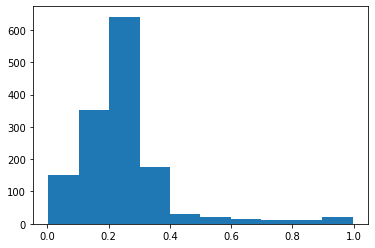

In [ ]:
plt.hist(df.weighted_leakage.values), df.weighted_leakage.values.mean()

In [ ]:
df.dropna(axis=0, inplace=True)
df.to_csv(f'{MOUNT_LOCATION}/db/X_group_{YEAR}_weight.csv', index=False)

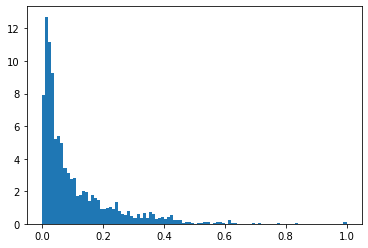

In [ ]:
plt.hist(df.leakage, bins=100, density=True);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


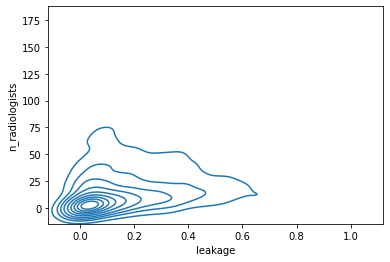

In [ ]:
import seaborn as sns

sns.kdeplot(df.leakage, df.n_radiologists)

In [ ]:
df

,group_practice_pac_id,n_referral,n_potential_referral,leakage,n_radiologists,normalized_rvu,to_latitude,to_longitude,ind_academic,average_day_wait
0,0042100380,429270.0,2337971.0,0.183608,75,1110.686000,40.765714,-73.98560,0,46.030628
1,0042105678,10763.0,312958.0,0.034391,1,134533.420000,40.695281,-80.32990,0,58.381239
2,0042109902,115527.0,1801580.0,0.064125,9,5202.822222,40.098110,-75.10949,0,57.940449
3,0042111981,18974.0,233922.0,0.081113,13,2787.886923,44.073930,-93.22716,1,61.258221
4,0042113110,42648.0,547702.0,0.077867,2,34191.345000,35.372730,-83.20772,0,62.091139
...,...,...,...,...,...,...,...,...,...,...
3299,9931298155,167184.0,765639.0,0.218359,47,4352.603830,46.809965,-95.85180,0,55.483416
3300,9931355799,18204.0,350189.0,0.051983,11,1267.526364,20.889294,-156.50497,0,51.830729
3301,9931359601,141782.0,2286934.0,0.061997,12,12797.218333,46.554402,-87.42223,0,58.867894
3302,9931377579,33.0,262.0,0.125954,1,120.720000,0.000000,0.00000,0,56.500000


## EDA

# Analysis of top CPT codes

In [ ]:
query = """
select * from docgraph
"""
#   where trim(pc.hcpcs_code) in ('77084', '75554', '75555', '75552', '75553', '75556', '75565', '75557', '75558', '75560', '75559', '75564', '75562', '75563', '75561', '76375', '74177', '74176', '74178', '74160', '74170', '74150', '74174', '74175', '71275', '70496', '73706', '70498', '72191', '73206', '76071', '76070', '77079', '77078', '72126', '72127', '72125', '74263', '74262', '74261', '76360', '76370', '76355', '76362', '77013', '77012', '77014', '77011', '70460', '70470', '70450', '75572', '75571', '75573', '76380', '73701', '73702', '73700', '72132', '72133', '72131', '70487', '70488', '70486', '70481', '70482', '70480', '72193', '72194', '72192', '70491', '70492', '70490', '72129', '72130', '72128', '71260', '71270', '71250', '73201', '73202', '73200', '75635', '75574', '77022', '77021', '74185', '71555', '70545', '70546', '70544', '73725', '70548', '70549', '70547', '72198', '72159', '73225', '76393', '76394', '74182', '74183', '74181', '73722', '73723', '73721', '73222', '73223', '73221', '76400', '70552', '70551', '70553', '70554', '70555', '70558', '70559', '70557', '77059', '77058', '76094', '76093', '71551', '71552', '71550', '73719', '73720', '73718', '70542', '70543', '70540', '72196', '72197', '72195', '76390', '72142', '72156', '72141', '72149', '72158', '72148', '72147', '72157', '72146', '73220', '73219', '73218', '76497', '76498') 
#select pc.hcpcs_code, sum(pc.bene_unique_cnt) as sum_bene_unique_cnt
#  from docgraph x 
#    inner join puf_detail pc 
#    on x.to_npi = pc.npi
#  group by pc.hcpcs_code]

#select pc.hcpcs_code, sum(pc.bene_unique_cnt) as sum_bene_unique_cnt
#  from puf_detail pc
#    inner join (select distinct to_npi from docgraph) x 
#    on x.to_npi = pc.npi
#  group by pc.hcpcs_code

df = pd.read_sql_query(query, engine)

In [ ]:
query = """SELECT name FROM sqlite_master WHERE type='table';
"""

df = pd.read_sql_query(query, engine)
df


,name
0,npi
1,puf
2,zipcode
3,docgraph
4,academic
5,sdi
6,rvu
7,puf_detail
8,zip_urban
9,valid_referer


In [ ]:
query = """SELECT * FROM docgraph
"""

df = pd.read_sql_query(query, engine)
df




,index,from_npi,to_npi,patient_count,average_day_wait,npi
0,0,1003863580,1003018870,18,86.579,1003018870
1,1,1033151279,1003018870,46,83.085,1003018870
2,2,1033142054,1003018870,17,72.824,1003018870
3,3,1023358850,1003018870,16,82.875,1003018870
4,4,1033114228,1003018870,25,74.200,1003018870
...,...,...,...,...,...,...
22124378,22124378,1194810531,1235143504,76,0.000,1235143504
22124379,22124379,1194776757,1871684746,11,3.273,1871684746
22124380,22124380,1225060742,1679501100,12,0.000,1679501100
22124381,22124381,1184786527,1285647701,12,11.083,1285647701


In [ ]:
df.to_csv(f'{MOUNT_LOCATION}/db/group_zip_{YEAR}.csv', index=False)

In [ ]:
df.sort_values('sum_bene_unique_cnt', ascending=False, inplace=True)

In [ ]:
df = df.iloc[:50].copy()
df

,index,from_npi,to_npi,patient_count,average_day_wait,npi
0,0,1003863580,1003018870,18,86.579,1003018870
1,1,1033151279,1003018870,46,83.085,1003018870
2,2,1033142054,1003018870,17,72.824,1003018870
3,3,1023358850,1003018870,16,82.875,1003018870
4,4,1033114228,1003018870,25,74.200,1003018870
5,5,1023030152,1003018870,56,58.051,1003018870
6,6,1023071479,1003018870,12,60.667,1003018870
7,7,1023061405,1003018870,137,84.331,1003018870
8,8,1003848813,1003018870,113,60.539,1003018870
9,9,1003260480,1003018870,77,84.359,1003018870


In [ ]:
from google.colab import files
df.to_csv ("docgraph2017_rad_dataframe.csv", index = False, header=True)




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/docgraph2017_rad_dataframe.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X = df[['leakage', 'n_radiologists', 'average_day_wait', 'normalized_rvu', 'distance', 'ind_academic']].copy()

In [ ]:
X

,leakage,n_radiologists,average_day_wait,normalized_rvu,distance,ind_academic
0,0.015566,22,62.856500,15669.197273,102.028422,1
1,0.906226,8,49.516250,5707.207500,0.000000,0
2,0.078208,2,84.184500,14595.950000,0.000000,0
3,0.705882,20,59.030200,5375.251500,81.813622,0
4,0.076923,110,76.235000,9638.066545,86.071220,1
...,...,...,...,...,...,...
1485668,0.065811,48,75.902000,16923.942083,3374.704582,1
1485669,0.934189,28,76.516130,18557.210714,22.353602,1
1485670,0.020104,4,70.852000,21575.292500,13.988972,0
1485671,0.026806,155,51.243000,6585.099032,381.335206,1


In [ ]:
X = X.fillna(0)

In [ ]:
X

,leakage,n_radiologists,average_day_wait,normalized_rvu,distance,ind_academic
0,0.015566,22,62.856500,15669.197273,102.028422,1
1,0.906226,8,49.516250,5707.207500,0.000000,0
2,0.078208,2,84.184500,14595.950000,0.000000,0
3,0.705882,20,59.030200,5375.251500,81.813622,0
4,0.076923,110,76.235000,9638.066545,86.071220,1
...,...,...,...,...,...,...
1485668,0.065811,48,75.902000,16923.942083,3374.704582,1
1485669,0.934189,28,76.516130,18557.210714,22.353602,1
1485670,0.020104,4,70.852000,21575.292500,13.988972,0
1485671,0.026806,155,51.243000,6585.099032,381.335206,1


In [ ]:
import seaborn as sns

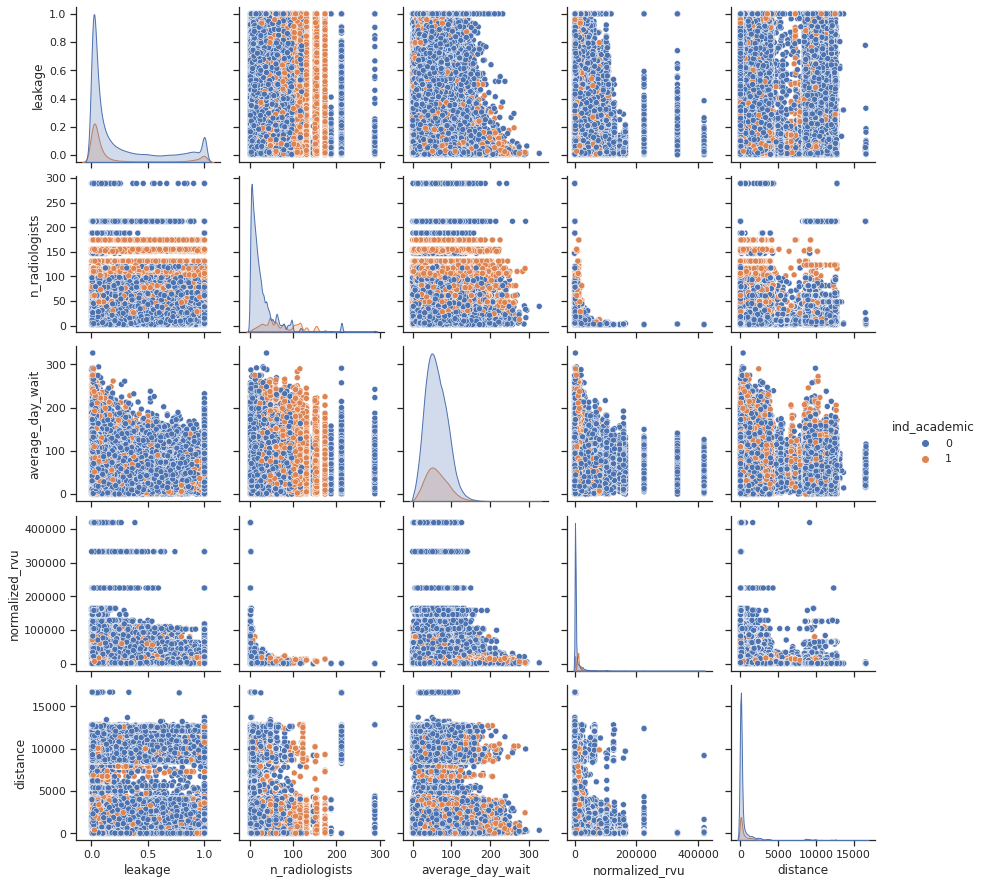

In [ ]:
sns.set_theme(style="ticks")

sns.pairplot(X, hue="ind_academic")